In [1]:
from run_ib import RunIB
from enumerate_lexicons import get_random_lexicon
import enumerate_lexicons as el
from ib import ib, mi, information_plane
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import math
from stirling import stirling
import enumerate_lexicons
pd.options.display.max_rows = 250
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.stats import linregress
import scipy
import pickle as pkl

# Fit $\gamma$ for each real lexicon

NOTE: in this notebook, we have to define the metric as 

$J_{IB} = I[M;U] - \gamma I[M;W]$ 



In [2]:
logsp = np.logspace(0,2,num = 1500)
mu = 0.3
num_dists = 3
pgs_dists = [0,0.789,-1.315]

In [17]:
def gamma_curve(mu, pgs = pgs_dists):
    i = 0
    curve = pd.DataFrame(data = {'gamma': [],
                            'informativity' : [],
                            'complexity' : []})
    qW_M = [None] * logsp.shape[0]
    
    for gamma in logsp:
        informativity = None
        complexity = None
        F = None
        x = RunIB(mu, gamma, num_dists, pgs)
        for num_words in range(2, 3*num_dists + 1):
            q_w_m_temp = ib(x.prior, x.prob_u_given_m, num_words, gamma, num_iter = 100) 
            informativity_temp, complexity_temp = information_plane(x.prior, x.prob_u_given_m, q_w_m_temp)
            F_temp = complexity_temp - gamma * informativity_temp
            if num_words == 2:
                F = F_temp
                informativity = informativity_temp
                complexity = complexity_temp
                q_w_m = q_w_m_temp
            else:
                if F_temp < F:
                    F = F_temp
                    informativity = informativity_temp
                    complexity = complexity_temp
                    q_w_m = q_w_m_temp
                    
        curve0 = pd.DataFrame({'gamma': gamma, 'informativity': informativity,
                             'complexity': complexity}, index = [0])
        curve = pd.concat([curve, curve0], ignore_index = True, axis = 0)
        qW_M[i] = q_w_m
        i+=1
        
    return curve, qW_M
            
obj = gamma_curve(mu)
curve = obj[0]
qW_M = obj[1]

In [5]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1),
               np.linspace(p1[1], p2[1], parts+1))

In [6]:
x = RunIB(mu,2,num_dists, pgs_dists)
num_meanings = 3 * num_dists
lexicon_size_range = range(2, num_meanings + 1)
sim_lex_dict = {lexicon_size: [lexicon for lexicon in enumerate_lexicons.enumerate_possible_lexicons(num_meanings, lexicon_size)] for 
        lexicon_size in lexicon_size_range}

In [7]:
lexicons = x.get_real_langs(num_meanings)

df = pd.DataFrame([{dm: l[1].argmax(axis=1)[dm_num]
                        for dm_num, dm in enumerate(x.deictic_index)} for l in lexicons])
information_plane_list = [information_plane(x.prior, x.prob_u_given_m, l[1]) for l in lexicons]
df["I[U;W]"] = [l[0] for l in information_plane_list]
df["I[M;W]"] = [l[1] for l in information_plane_list]
df["Language"] = [l[0] for l in lexicons]
df["Area"] = [l[2] for l in lexicons]

/Users/cshnican/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/cshnican/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/cshnican/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/cshnican/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
lexicons_sim = []
for lexicon_size in range(2, num_meanings+1):
    all_lex = sim_lex_dict[lexicon_size]
    lexicons_sim += [("simulated", l[1], "simulated") for l in all_lex]

df_sim = pd.DataFrame([{dm: l[1].argmax(axis=1)[dm_num]
                        for dm_num, dm in enumerate(x.deictic_index)} for l in lexicons_sim])

information_plane_list_sim = [information_plane(x.prior, x.prob_u_given_m, l[1]) for l in lexicons_sim]
df_sim["I[U;W]"] = [l[0] for l in information_plane_list_sim]
df_sim["I[M;W]"] = [l[1] for l in information_plane_list_sim]
df_sim["Language"] = [l[0] for l in lexicons_sim]
df_sim["Area"] = [l[2] for l in lexicons_sim]

sim_only_plane = np.array([[l[0], l[1]] for l in information_plane_list_sim])
real_only_plane = np.array(df[["I[U;W]", "I[M;W]"]])


In [26]:
# deterministic frontier
curve_det =  pd.DataFrame()
gammas = []
informativity = []
complexity = []
argmins = []
for gamma in logsp:
    f = df_sim["I[M;W]"].values - gamma * df_sim["I[U;W]"].values
    gammas += [gamma]
    informativity += [df_sim["I[U;W]"].values[f.argmin()]]
    complexity += [df_sim["I[M;W]"].values[f.argmin()]]
    argmins += [f.argmin()]

curve_det["informativity"] = informativity
curve_det["complexity"] = complexity
curve_det["gamma"] = gammas

for dm_num, dm in enumerate(x.deictic_index):
    curve_det[dm] = [df_sim[dm][a] for a in argmins]

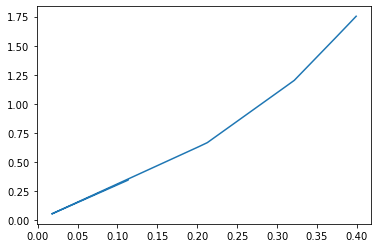

In [9]:
vertices = ConvexHull(sim_only_plane).vertices
pv = sim_only_plane[vertices] # this is the hull
resid = pv[:, 1] - (linregress(sim_only_plane).intercept +
                    pv[:, 0] * linregress(sim_only_plane).slope)
vertices = vertices[resid < 0]  # just the bottom part of hull

# fill in between the points
verts = []
for i, j in zip(pv, np.array(list(pv[1:, :]) + list([pv[0, :]]))):
    if i[0] < j[0]:
        verts += list(getEquidistantPoints(i, j, 100))
verts = np.array(verts)

dists = euclidean_distances(real_only_plane, verts).min(axis=1)
dists_sim = euclidean_distances(sim_only_plane, verts).min(axis=1)

df["dist_to_hull"] = dists
df_sim["dist_to_hull"] = dists_sim

plt.figure()
plt.plot(df_sim.loc[df_sim["dist_to_hull"] < 0.0001]["I[U;W]"], 
         df_sim.loc[df_sim["dist_to_hull"] < 0.0001]["I[M;W]"])



In [27]:
df.to_csv('sheets/real_lexicons_fit_mu_' + str(mu) + '_pgs_' + "_".join([str(pgs) for pgs in pgs_dists]) + 'num_dists_' + str(num_dists) + '.csv')
df_sim.to_csv('sheets/sim_lexicons_fit_mu_'+ str(mu) + '_pgs_' + "_".join([str(pgs) for pgs in pgs_dists]) + 'num_dists_' + str(num_dists) +'.csv')
curve.to_csv('sheets/ib_curve_non_deter_mu_' + str(mu) + '_pgs_' + "_".join([str(pgs) for pgs in pgs_dists]) + 'num_dists_' + str(num_dists) +'.csv')
curve_det.to_csv('sheets/ib_curve_deter_mu_' + str(mu) + '_pgs_' + "_".join([str(pgs) for pgs in pgs_dists]) + 'num_dists_' + str(num_dists) +'.csv')

#df_verts = pd.DataFrame({"informativity": verts[:,0], "complexity": verts[:,1]})
#df_verts.to_csv('sheets/ib_frontier_mu_'+ str(mu) + '_pgs_' + "_".join([str(pgs) for pgs in pgs_dists])+ 'num_dists_' + str(num_dists) +'.csv')

,informativity,complexity,gamma,D1_place,D2_place,D3_place,D1_goal,D2_goal,D3_goal,D1_source,D2_source,D3_source
0,0.017773,0.055862,1.000000,0,0,0,0,0,0,0,0,1
1,0.017773,0.055862,1.003077,0,0,0,0,0,0,0,0,1
2,0.017773,0.055862,1.006163,0,0,0,0,0,0,0,0,1
3,0.017773,0.055862,1.009259,0,0,0,0,0,0,0,0,1
4,0.017773,0.055862,1.012364,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.398995,1.753061,98.778655,0,1,2,3,4,5,6,7,8
1496,0.398995,1.753061,99.082586,0,1,2,3,4,5,6,7,8
1497,0.398995,1.753061,99.387451,0,1,2,3,4,5,6,7,8
1498,0.398995,1.753061,99.693255,0,1,2,3,4,5,6,7,8
